In [1]:
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

import keras
import imageio
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

video_path = r"S:\Wormax\data\nn\resized.mp4"
resolution = (96, 60)
input_frames_number = 4

Using TensorFlow backend.


In [2]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K
from keras.layers import BatchNormalization

input_img = Input(shape=(resolution[1], resolution[0], 3 * input_frames_number))
n = 64
x = Conv2D(n, (4, 4), strides=(2, 2), activation='relu', padding='same')(input_img)
x = BatchNormalization()(x)
x = Conv2D(n, (4, 4), strides=(2, 2), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(n, (4, 4), strides=(2, 2), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
encoded = x

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(n, (4, 4), activation='relu', padding='same')(encoded)
x = BatchNormalization()(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(n, (4, 4), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(n, (4, 4), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(3, (4, 4), activation='sigmoid', padding='same')(x)
decoded = keras.layers.Cropping2D((2, 0))(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [3]:
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 60, 96, 12)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 48, 64)        12352     
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 48, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 24, 64)        65600     
_________________________________________________________________
batch_normalization_2 (Batch (None, 15, 24, 64)        256       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 12, 64)         65600     
_________________________________________________________________
batch_normalization_3 (Batch (None, 8, 12, 64)         256 

In [4]:
def help_generator(video_path, offset=0):
    while True:
        cap = cv2.VideoCapture(video_path)
        for i in range(offset):
            ret, frame = cap.read()

        ret = True
        while ret:
            ret, frame = cap.read()
            frame = frame / 255
            yield frame
            

def generator(video_path, input_frames_number, batch_size, buffer_size, offset=0):
    buffer = []
    gen = help_generator(video_path, offset)
    while True:
        while len(buffer) < buffer_size:
            buffer.append([np.dstack([next(gen) for i in range(input_frames_number)]),
                           next(gen)])
        np.random.shuffle(buffer)
        batch = buffer[:batch_size]
        x, y = zip(*batch)
        buffer = buffer[batch_size:]
        yield np.array(x), np.array(y)
        
gen = generator(video_path, 
                input_frames_number,
                batch_size=32,
                buffer_size=1024)
x, y = next(gen)
print(x.shape)
print(y.shape)

(32, 60, 96, 12)
(32, 60, 96, 3)


In [5]:
from keras.callbacks import TensorBoard
from keras_tqdm import TQDMNotebookCallback
import time

gen = generator(video_path, 
                input_frames_number,
                batch_size=32,
                buffer_size=1024)

val_gen = generator(video_path, 
                input_frames_number,
                batch_size=32,
                buffer_size=1024,
                offset=30*60*10)


autoencoder.fit_generator(gen,
                          steps_per_epoch=100,
                          validation_steps=1,
                          epochs=50,
                          shuffle=True,
                          validation_data=val_gen,
                          callbacks=[TensorBoard(log_dir=f'/tmp/autoencoder-4imgs-{time.time()}'),
                                    TQDMNotebookCallback()],
                          verbose=0)


TypeError: unsupported operand type(s) for /: 'NoneType' and 'int'

In [ ]:
from keras.models import load_model

autoencoder.save('my_model.h5') 
del autoencoder  # deletes the existing model
autoencoder = load_model('my_model.h5')

In [6]:
gen = generator(video_path, input_frames_number=30, batch_size=1, buffer_size=100, offset=100)
for j in range(100):
    x, y = next(gen)
    seq = x[0]

    for i in range(100):
        prediction = autoencoder.predict(np.expand_dims(seq[:, :, -3 * input_frames_number:], axis=0))
        seq = np.dstack((seq, prediction[0]))

    for i in range(130):
        i = i % 130
        img = seq[:, :, (i + 0) * 3:(i + 1 + 0) * 3]
        cv2.imshow('name', cv2.resize(img, (960, 800), interpolation=cv2.INTER_NEAREST))
        cv2.waitKey(50)

KeyboardInterrupt: 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# Artificial data generation:
# Generate movies with 3 to 7 moving squares inside.
# The squares are of shape 1x1 or 2x2 pixels,
# which move linearly over time.
# For convenience we first create movies with bigger width and height (80x80)
# and at the end we select a 40x40 window.

def generate_movies(n_samples=1200, n_frames=15):
    row = 80
    col = 80
    noisy_movies = np.zeros((n_samples, n_frames, row, col, 1), dtype=np.float)
    shifted_movies = np.zeros((n_samples, n_frames, row, col, 1),
                              dtype=np.float)

    for i in range(n_samples):
        # Add 3 to 7 moving squares
        n = np.random.randint(3, 8)

        for j in range(n):
            # Initial position
            xstart = np.random.randint(20, 60)
            ystart = np.random.randint(20, 60)
            # Direction of motion
            directionx = np.random.randint(0, 3) - 1
            directiony = np.random.randint(0, 3) - 1

            # Size of the square
            w = np.random.randint(2, 4)

            for t in range(n_frames):
                x_shift = xstart + directionx * t
                y_shift = ystart + directiony * t
                noisy_movies[i, t, x_shift - w: x_shift + w,
                             y_shift - w: y_shift + w, 0] += 1

                # Make it more robust by adding noise.
                # The idea is that if during inference,
                # the value of the pixel is not exactly one,
                # we need to train the network to be robust and still
                # consider it as a pixel belonging to a square.
                if np.random.randint(0, 2):
                    noise_f = (-1)**np.random.randint(0, 2)
                    noisy_movies[i, t,
                                 x_shift - w - 1: x_shift + w + 1,
                                 y_shift - w - 1: y_shift + w + 1,
                                 0] += noise_f * 0.1

                # Shift the ground truth by 1
                x_shift = xstart + directionx * (t + 1)
                y_shift = ystart + directiony * (t + 1)
                shifted_movies[i, t, x_shift - w: x_shift + w,
                               y_shift - w: y_shift + w, 0] += 1

    # Cut to a 40x40 window
    noisy_movies = noisy_movies[::, ::, 20:60, 20:60, ::]
    shifted_movies = shifted_movies[::, ::, 20:60, 20:60, ::]
    noisy_movies[noisy_movies >= 1] = 1
    shifted_movies[shifted_movies >= 1] = 1
    return noisy_movies, shifted_movies

In [2]:
mov1, mov2 = generate_movies()

In [8]:
import cv2
for i in range(1500):
    img = mov1[i // 15][i % 15]
    cv2.imshow('2', cv2.resize(img, (400, 400), interpolation=cv2.INTER_NEAREST))
    cv2.waitKey(33)

In [2]:
"""
#This script demonstrates the use of a convolutional LSTM network.
This network is used to predict the next frame of an artificially
generated movie which contains moving squares.
"""
from keras.models import Sequential
from keras.layers.convolutional import Conv3D
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras.layers.normalization import BatchNormalization
import numpy as np

# We create a layer which take as input movies of shape
# (n_frames, width, height, channels) and returns a movie
# of identical shape.

seq = Sequential()
seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
                   input_shape=(None, 40, 40, 1),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

seq.add(Conv3D(filters=1, kernel_size=(3, 3, 3),
               activation='sigmoid',
               padding='same', data_format='channels_last'))
seq.compile(loss='binary_crossentropy', optimizer='adam')


Using TensorFlow backend.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
seq.summary()

In [5]:
from keras.callbacks import TensorBoard
from keras_tqdm import TQDMNotebookCallback
import time

# Train the network
noisy_movies, shifted_movies = generate_movies(n_samples=1200)
seq.fit(noisy_movies[:1000], shifted_movies[:1000], batch_size=10,
        epochs=500, validation_split=0.05,
        callbacks=[TensorBoard(log_dir=f'/tmp/vid_predict-{time.time()}'),
                                    TQDMNotebookCallback()],
       verbose=0)

KeyboardInterrupt: 

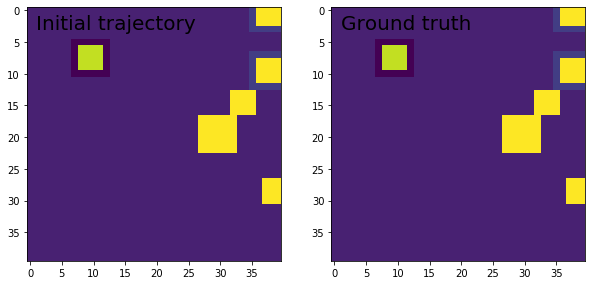

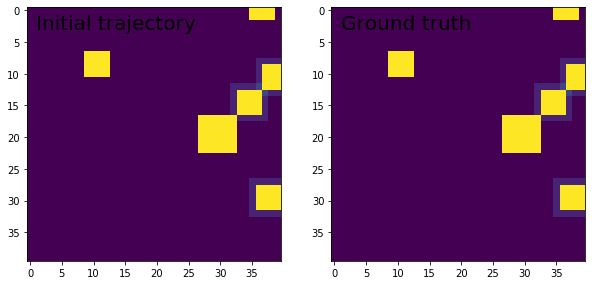

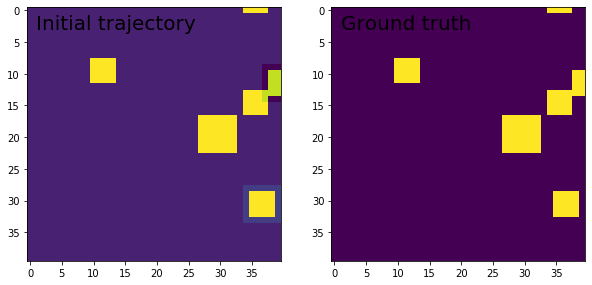

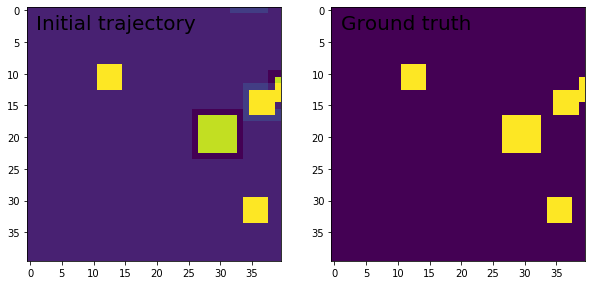

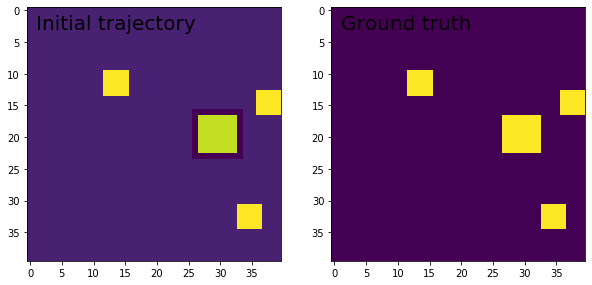

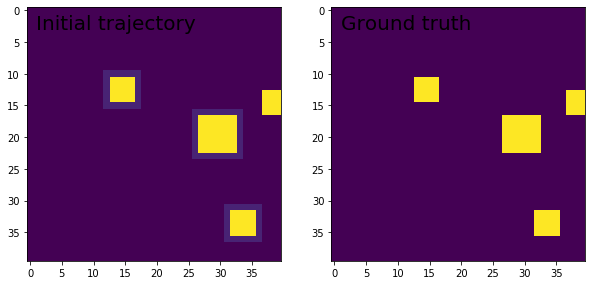

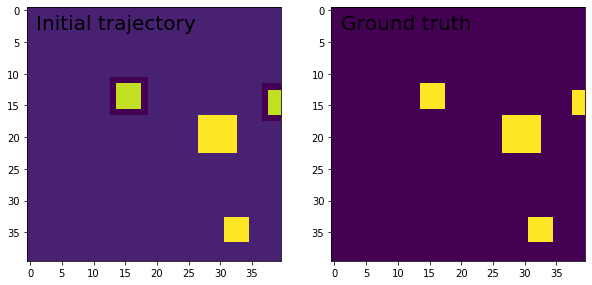

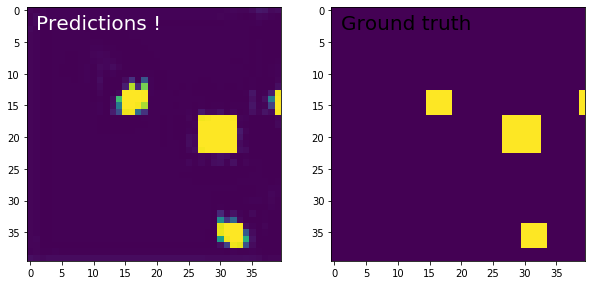

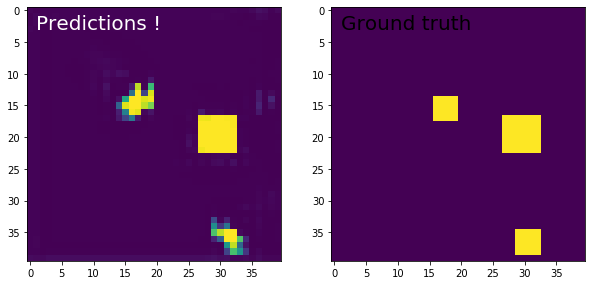

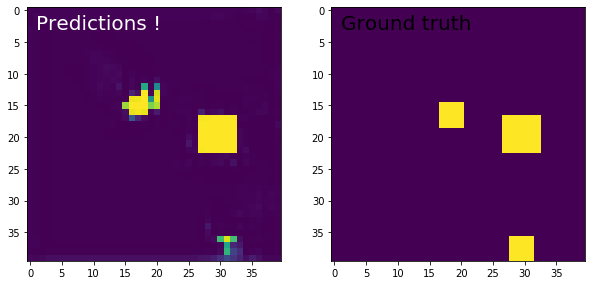

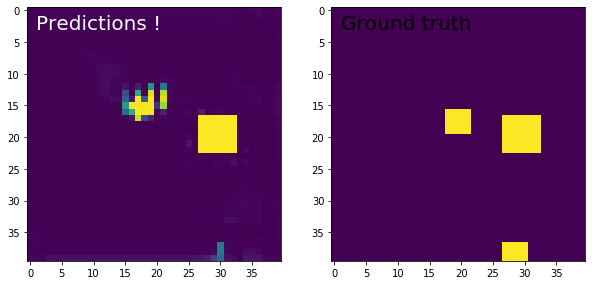

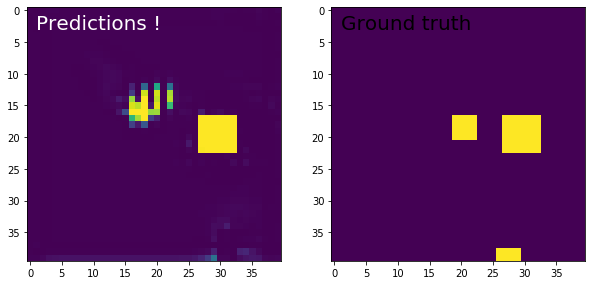

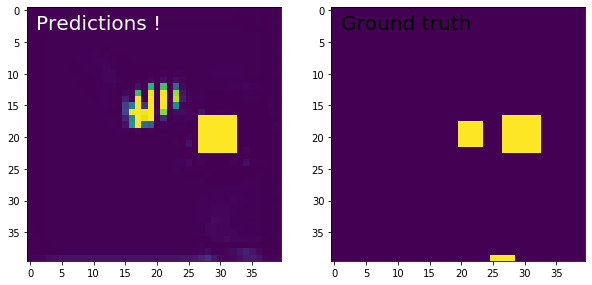

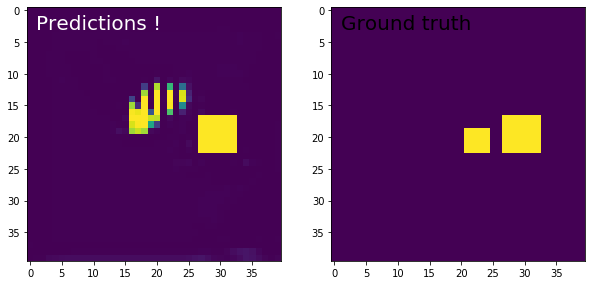

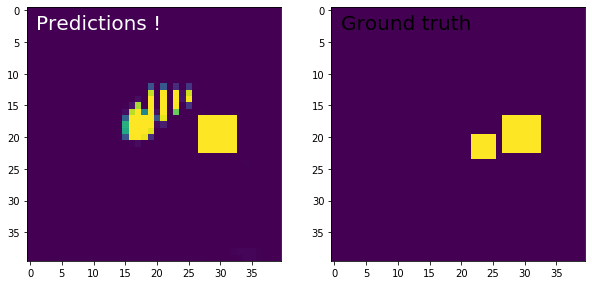

In [6]:
# Testing the network on one movie
# feed it with the first 7 positions and then
# predict the new positions
which = 1004
track = noisy_movies[which][:7, ::, ::, ::]

for j in range(16):
    new_pos = seq.predict(track[np.newaxis, ::, ::, ::, ::])
    new = new_pos[::, -1, ::, ::, ::]
    track = np.concatenate((track, new), axis=0)


# And then compare the predictions
# to the ground truth
track2 = noisy_movies[which][::, ::, ::, ::]
for i in range(15):
    fig = plt.figure(figsize=(10, 5))

    ax = fig.add_subplot(121)

    if i >= 7:
        ax.text(1, 3, 'Predictions !', fontsize=20, color='w')
    else:
        ax.text(1, 3, 'Initial trajectory', fontsize=20)

    toplot = track[i, ::, ::, 0]

    plt.imshow(toplot)
    ax = fig.add_subplot(122)
    plt.text(1, 3, 'Ground truth', fontsize=20)

    toplot = track2[i, ::, ::, 0]
    if i >= 2:
        toplot = shifted_movies[which][i - 1, ::, ::, 0]

    plt.imshow(toplot)
    plt.savefig('%i_animate.png' % (i + 1))